In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 7

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
39/39 [==============================] - 1s 4ms/step - loss: 1.8590 - accuracy: 0.2285 - val_loss: 1.7329 - val_accuracy: 0.2590

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
39/39 [==============================] - 0s 1ms/step - loss: 1.7457 - accuracy: 0.2803 - val_loss: 1.6455 - val_accuracy: 0.3446

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
39/39 [==============================] - 0s 1ms/step - loss: 1.6535 - accuracy: 0.3199 - val_loss: 1.5296 - val_accuracy: 0.4849

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
39/39 [==============================] - 0s 1ms/step - loss: 1.5670 - accuracy: 0.3631 - val_loss: 1.3697 - val_accuracy: 0.5837

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
39/39 [==============================] - 0s 1ms/step - loss: 1.4633 - accuracy: 0.4040 - val_lo


Epoch 00037: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 38/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.7824 - accuracy: 0.6916 - val_loss: 0.4254 - val_accuracy: 0.9108

Epoch 00038: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 39/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.7816 - accuracy: 0.6900 - val_loss: 0.4255 - val_accuracy: 0.9084

Epoch 00039: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 40/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.7734 - accuracy: 0.7006 - val_loss: 0.4128 - val_accuracy: 0.9114

Epoch 00040: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 41/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.7761 - accuracy: 0.7058 - val_loss: 0.4105 - val_accuracy: 0.9096

Epoch 00041: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 42/1000
39/39 [==

39/39 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.7492 - val_loss: 0.3271 - val_accuracy: 0.9283

Epoch 00074: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 75/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6794 - accuracy: 0.7528 - val_loss: 0.3312 - val_accuracy: 0.9295

Epoch 00075: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 76/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6616 - accuracy: 0.7550 - val_loss: 0.3239 - val_accuracy: 0.9265

Epoch 00076: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 77/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6594 - accuracy: 0.7506 - val_loss: 0.3240 - val_accuracy: 0.9283

Epoch 00077: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 78/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6657 - accuracy: 0.7522 - val_loss: 0.327


Epoch 00110: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 111/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6284 - accuracy: 0.7647 - val_loss: 0.3039 - val_accuracy: 0.9325

Epoch 00111: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 112/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6187 - accuracy: 0.7669 - val_loss: 0.3052 - val_accuracy: 0.9398

Epoch 00112: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 113/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6142 - accuracy: 0.7681 - val_loss: 0.2981 - val_accuracy: 0.9367

Epoch 00113: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 114/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.6103 - accuracy: 0.7685 - val_loss: 0.3096 - val_accuracy: 0.9295

Epoch 00114: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 115/1000
39/3

39/39 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7829 - val_loss: 0.2936 - val_accuracy: 0.9380

Epoch 00147: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 148/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.5906 - accuracy: 0.7789 - val_loss: 0.2907 - val_accuracy: 0.9373

Epoch 00148: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 149/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.5839 - accuracy: 0.7795 - val_loss: 0.3009 - val_accuracy: 0.9325

Epoch 00149: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 150/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.5934 - accuracy: 0.7753 - val_loss: 0.2857 - val_accuracy: 0.9398

Epoch 00150: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 151/1000
39/39 [==============================] - 0s 1ms/step - loss: 0.5840 - accuracy: 0.7779 - val_loss: 0

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 417us/step - loss: 0.2939 - accuracy: 0.9367


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[5.8788545e-02 8.9634991e-01 3.9446827e-02 1.4912331e-07 9.6540838e-09
 5.4139025e-03 6.6937548e-07]
1


# Confusion matrix

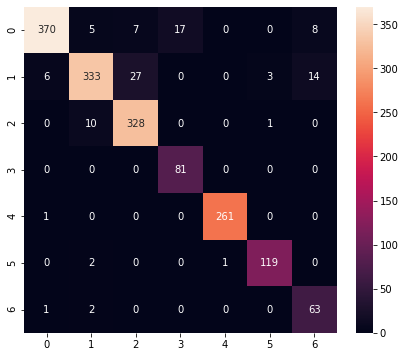

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       407
           1       0.95      0.87      0.91       383
           2       0.91      0.97      0.94       339
           3       0.83      1.00      0.91        81
           4       1.00      1.00      1.00       262
           5       0.97      0.98      0.97       122
           6       0.74      0.95      0.83        66

    accuracy                           0.94      1660
   macro avg       0.91      0.95      0.93      1660
weighted avg       0.94      0.94      0.94      1660



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\offic\AppData\Local\Temp\tmpoeyb2h3l\assets


6496

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2853570e-02 8.7526584e-01 9.5567100e-02 5.7637597e-14 3.6300818e-20
 6.3046576e-03 8.8413035e-06]
1
